#Multi-Class Text Classification with Doc2Vec & Logistic Regression
#Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method.

#dataset used is available at https://catalog.data.gov/dataset/consumer-complaint-database

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('complaints.csv')
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
df.head(10)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,narrative,Product
4,XXXX XXXX is a rip-off company that never giv...,Mortgage
10,I fell behind on my payments in XXXX when i go...,Vehicle loan or lease
12,Been trying to settle this debt for like 2 yea...,Debt collection
26,I was the victim of a job scam. I accepted the...,"Money transfer, virtual currency, or money ser..."
36,You have listed incorrect accounts on my credi...,"Credit reporting, credit repair services, or o..."
37,My loan transferred to Lakeview Loan Servicing...,Mortgage
38,My loan is XXXX XXXX XXXX on XX/XX/2023. \nI r...,Mortgage
52,"I do not know if this is a legit debtor, I rec...",Debt collection
53,In accordance with the Fair Credit Reporting a...,"Credit reporting, credit repair services, or o..."
56,Wells Fargo illegally sold my mortgage while i...,Mortgage


#After remove null values in narrative columns, we will need to re-index the data frame.

In [2]:
df.shape

(1450320, 2)

In [3]:
df.index = range(1450320)
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

269686376

# we have 269 million words

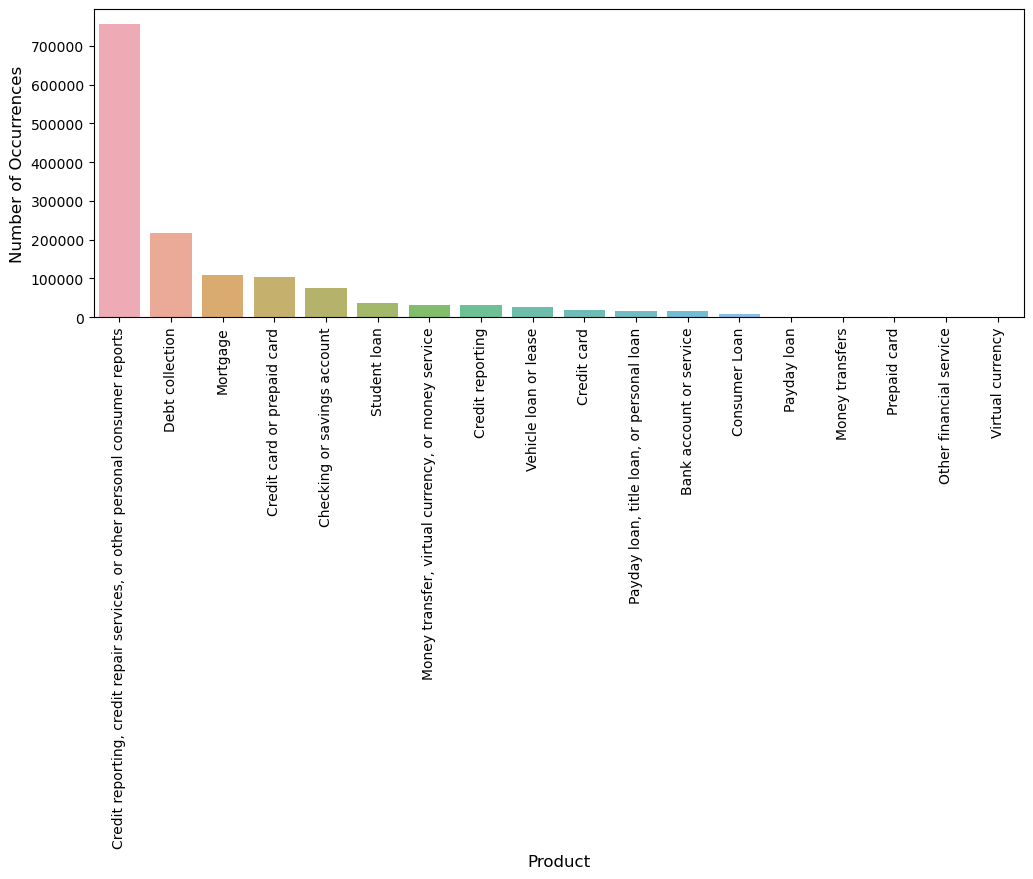

In [4]:
#Exploring

cnt_pro = df['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

#The classes are imbalanced, however, a naive classifier that predicts everything to be Debt collection will only achieve over 20% accuracy.

In [5]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

print_complaint(12)

Recently, I filed a complaint with this agency as to false, fraudulent, inaccurate and misleading information Experian credit reporting agency was reporting on my Experian credit report. Specifically, a creditor, XXXXXXXX XXXX XXXXXXXX. Experian was reporting this creditor that was included in a bankruptcy in XXXX as charged off, written off and past due as of XX/XX/XXXX, XX/XX/XXXX and recently XX/XX/XXXX with a balance of {$9200.00}. This false an inaccurate statement by Experian just started in XX/XX/XXXX. Doing this, Experian caused my fico score to drop XXXX points, from XXXX to XXXX, which caused me to pay higher insurance premiums, be denied credit card increase requests and credit denials. Since my XXXX complaint with your agency, dated XX/XX/XXXX then again with additional evidence and information on XX/XX/XXXX ( see attached two complaint ID # s ) Experian representative XXXX XXXX, a Senior Regulatory Affairs Associate wrote back to the XXXX  on XX/XX/XXXX ( see attached lett

In [6]:
print_complaint(20)

The current issue is causing me significant distress and is having a negative impact on my sleep. It is challenging for me to accept this situation.
Product: Credit card or prepaid card


#Text Preprocessing

*Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [7]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_79398/616686574.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


#The following steps include train/test split of 70/30, remove stop-words and tokenize text using NLTK tokenizer. For our first try we tag every complaint narrative with its product.

In [8]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [9]:
import nltk
from nltk.corpus import stopwords

In [10]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [11]:
#This step takes a very long time if it is run on a CPU
# Make use of TPUs or GPUs
#Hardware support accelerates tagging of all the words in the dataset.

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

In [12]:
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

In [13]:
train_tagged.values[30]

TaggedDocument(words=['my', 'wallet', 'was', 'stolen', 'with', 'my', 'id', 'ss-card', 'bank', 'card', 'cash', 'and', 'more', 'person', 'information', 'the', 'wallet', 'was', 'sent', 'back', 'to', 'me', 'from', 'florida', 'with', 'only', 'the', 'id', 'and', 'bank', 'cards', 'went', 'to', 'the', 'bank', 'and', 'cancel', 'the', 'cards', 'and', 'got', 'replacement', 'started', 'receiving', 'calls', 'about', 'collecting', 'debt', 'thought', 'it', 'was', 'scam', 'call', 'so', 'never', 'took', 'it', 'into', 'consideration', 'that', 'it', 'was', 'real', 'then', 'seen', 'on', 'my', 'credit', 'that', 'another', 'card', 'was', 'open', 'and', 'using', 'my', 'address', 'and', 'information', 'contact', 'the', 'credit', 'bureaus', 'and', 'file', 'dispute', 'and', 'contact', 'and', 'told', 'them', 'my', 'identity', 'was', 'stolen', 'back', 'in', '//', 'and', 'that', 'never', 'open', 'the', 'account', 'and', 'they', 'didnt', 'cancel', 'the', 'account', 'they', 'told', 'me', 'to', 'send', 'them', 'the',

Set-up Doc2Vec Training & Evaluation Models

We will vary the following parameters:

    If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used.
    300- dimensional feature vectors.
    min_count=2, ignores all words with total frequency lower than this.
    negative=5 , specifies how many “noise words” should be drawn.
    hs=0 , and negative is non-zero, negative sampling will be used.
    sample=0 , the threshold for configuring which higher-frequency words are randomly down sampled.
    workers=cores , use these many worker threads to train the model (=faster training with multicore machines).

In [14]:
import multiprocessing
cores = multiprocessing.cpu_count()

#Building a Vocabulary

In [15]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, 
                     min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|████████████████████████████| 1015224/1015224 [00:00<00:00, 1897043.16it/s]


#Training a doc2vec model is rather straight-forward in Gensim, we initialize the model and train for 30 epochs.

In [16]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████| 1015224/1015224 [00:00<00:00, 2652142.55it/s]


CPU times: user 2h 40min 28s, sys: 41min 12s, total: 3h 21min 41s
Wall time: 3h 40min 57s


#Building the Final Vector Feature for the Classifier

In [20]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

#def vec_for_learning(model, tagged_docs):
    #sents = tagged_docs.values
    #targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    #return targets, regressors

In [21]:
#Train the Logistic Regression Classifier.
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


/Users/zaarr/opt/anaconda3/envs/Tensorflow_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing accuracy 0.5216228142754702
Testing F1 score: 0.3587871807184659


In [22]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5216228142754702
Testing F1 score: 0.3587871807184659


In [23]:
#Distributed Memory (DM)
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, 
                    min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])



100%|█████████████████████████████| 1015224/1015224 [00:01<00:00, 571970.44it/s]


In [24]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), 
                    total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|████████████████████████████| 1015224/1015224 [00:00<00:00, 2335195.03it/s]


CPU times: user 4h 57min 40s, sys: 37min 29s, total: 5h 35min 9s
Wall time: 14h 48min 18s
